<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/posts/08wk-3.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상 

In [ ]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-zBs464epBRfxPpNBAKqBMS&si=It99ZTYMQHJkCk6z >}}

# 2. Imports 

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
#---#
import torch
import transformers
import tarfile

# 3. `with`

## A. 기본사용

`-` 아래와 같이 with를 사용한다. 여기에서 `컨텍스트_관리_객체`란 `__enter__` 와 `__exit__`을 포함하는 어떠한 오브젝트이다. 

```Python
with 컨텍스트_관리_객체:
    블라블라~
    야디야디~
```

`# 예제1` -- 기본예제

`-` context manager 

In [127]:
class Dummy: 
    def __enter__(self):
        print("enter")
    def __exit__(self,*args): # *args는 에러처리 관련된 기본변수들
        print("exit")

`-` 아래의 2개는 같은코드임.. 

In [128]:
d = Dummy()
d.__enter__()
print('context')
d.__exit__()

enter
context
exit


In [129]:
d = Dummy()
with d:
    print("context")


enter
context
exit


`#`

`-` with 뒤에 올수 있는 오브젝트는 `__enter__` 와 `__exit__` 을 포함해야한다. 

In [130]:
lst = [1,2,3]
with lst:
    pass

TypeError: 'list' object does not support the context manager protocol

In [131]:
class Dummy: 
    def __enter__(self):
        pass
    def __exit__(self,*args): # *args는 에러처리 관련된 기본변수들
        pass
with Dummy():
    pass

`# 예제2` -- 타이머

In [138]:
class Timer:
    def __enter__(self):
        self.start = time.time()
    def __exit__(self,*args):
        self.end = time.time()
        print(f'{self.end- self.start:.4f} 초 걸림')

In [140]:
with Timer():
    np.random.randn(10000,10000) + 30


1.5234 초 걸림


`#`

`# 예제3` 

In [173]:
class 미분꼬리표추적금지:
    def __enter__(self):
        torch.set_grad_enabled(False)
    def __exit__(self,*args):
        torch.set_grad_enabled(True)

In [174]:
a = torch.tensor([1.0,2,3],requires_grad=True)
b = a*10
a,b

(tensor([1., 2., 3.], requires_grad=True),
 tensor([10., 20., 30.], grad_fn=<MulBackward0>))

In [175]:
with 미분꼬리표추적금지():
    a = torch.tensor([1.0,2,3],requires_grad=True)
    b = a*10
a,b

(tensor([1., 2., 3.], requires_grad=True), tensor([10., 20., 30.]))

In [176]:
a = torch.tensor([1.0,2,3],requires_grad=True)
b = a*10
a,b

(tensor([1., 2., 3.], requires_grad=True),
 tensor([10., 20., 30.], grad_fn=<MulBackward0>))

`#`

`# 예제4` 

아래의 코드를 모델을 활용하여 로짓을 계산하라. 

In [190]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2
)
model_input = {
    'input_ids': torch.tensor([[101, 2023, 3185, 2003, 6659, 2021, 2009, 2038, 2070, 2204, 3896, 1012, 102]]),
    'attention_mask': torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
    'labels': torch.tensor([0])
}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`(풀이)`

In [191]:
model(**model_input)

SequenceClassifierOutput(loss=tensor(0.6349, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0272, -0.0929]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [193]:
logits = model(**model_input).logits
logits

tensor([[ 0.0272, -0.0929]], grad_fn=<AddmmBackward0>)

`(풀이2)`

그런데 이런코드도 많이 보셨을거에요.. 

In [194]:
with torch.no_grad():
    logits = model(**model_input).logits
logits

tensor([[ 0.0272, -0.0929]])

ref: <https://huggingface.co/docs/transformers/tasks/sequence_classification>

`-` 코드를 좀 뜯어봅시다.. 

In [195]:
context_manager = torch.no_grad()

In [198]:
context_manager.__enter__??

Signature: context_manager.__enter__() -> None
Docstring: <no docstring>
Source:   
    def __enter__(self) -> None:
        self.prev = torch.is_grad_enabled()
        torch.set_grad_enabled(False)
File:      ~/anaconda3/envs/hf/lib/python3.12/site-packages/torch/autograd/grad_mode.py
Type:      method

In [199]:
context_manager.__exit__??

Signature: context_manager.__exit__(exc_type: Any, exc_value: Any, traceback: Any) -> None
Docstring: <no docstring>
Source:   
    def __exit__(self, exc_type: Any, exc_value: Any, traceback: Any) -> None:
        torch.set_grad_enabled(self.prev)
File:      ~/anaconda3/envs/hf/lib/python3.12/site-packages/torch/autograd/grad_mode.py
Type:      method

`#`

## B. 약간고급사용 

`# 예비학습` 

`-` 기본플랏 

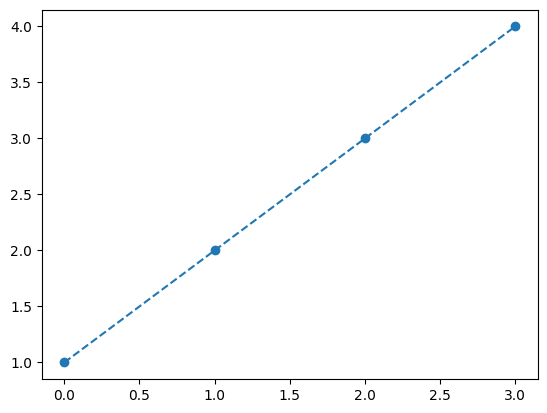

In [222]:
plt.plot([1,2,3,4],'--o')

`-` 크기를 (10,3)으로 조정

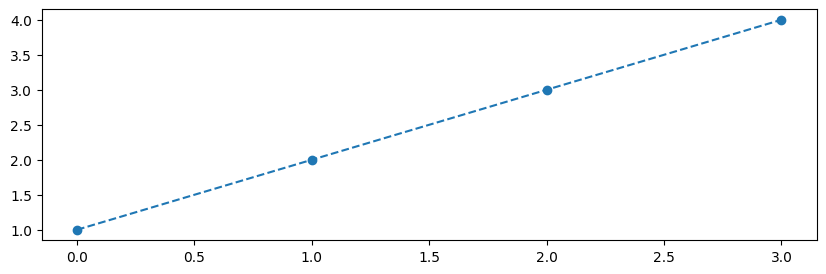

In [225]:
plt.rcParams['figure.figsize'] = (10, 3)
plt.plot([1,2,3,4],'--o',)

`-` 한번 뒤틀린 설정이 그대로 있음 

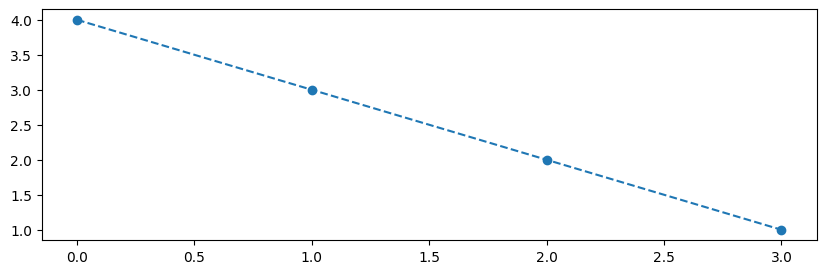

In [228]:
plt.plot([4,3,2,1],'--o') # 다른그림도 이렇게 보임

`-` 설정을 원래대로 

In [229]:
plt.rcdefaults()

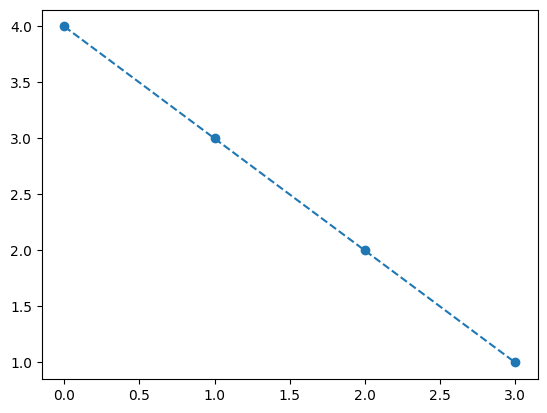

In [230]:
plt.plot([4,3,2,1],'--o') # 다른그림도 이렇게 보임

`#`

`# 예제4` -- 크기조정 

In [246]:
class FigureSizeContext:
    def __enter__(self):
        def resize(w,h):
            plt.rcParams['figure.figsize'] = (w,h)
        return resize
    def __exit__(self,*args):
        plt.rcdefaults()

`-` 사용예시1

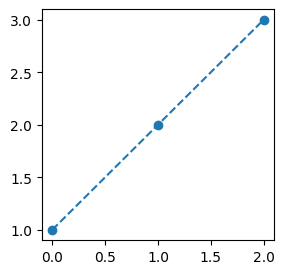

In [254]:
context_manager = FigureSizeContext()
resize = context_manager.__enter__()
resize(3,3)
plt.plot([1,2,3],'--o')
context_manager.__exit__()

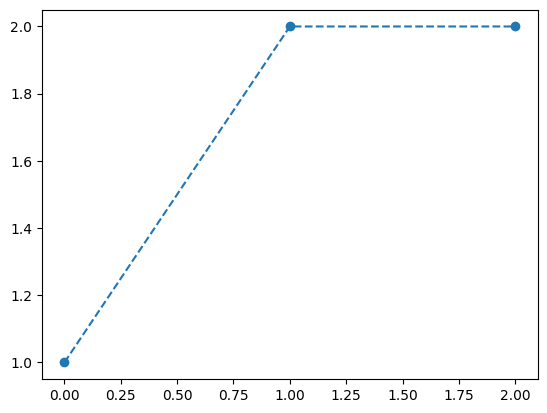

In [255]:
plt.plot([1,2,2],'--o')

`-` 사용예시2

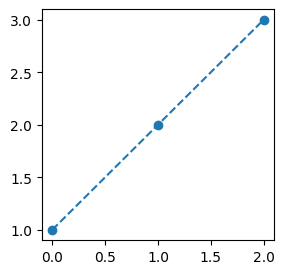

In [261]:
context_manager = FigureSizeContext()
with context_manager as resize:
    resize(3,3)
    plt.plot([1,2,3],'--o')

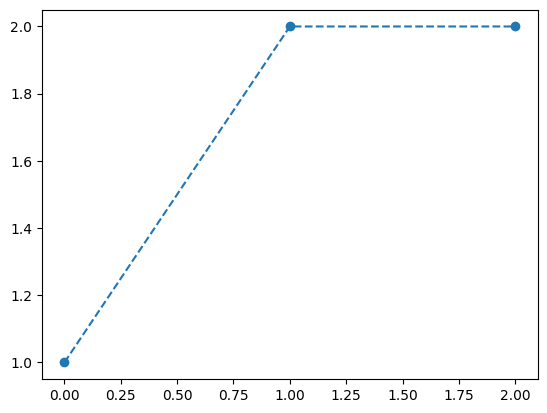

In [262]:
plt.plot([1,2,2],'--o')

`-` 정리하면 아래는 같은코드이다. 

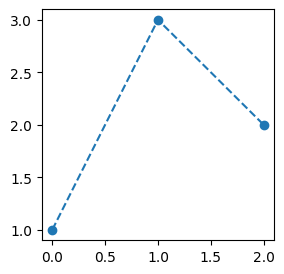

In [268]:
### 코드1
context_manager = FigureSizeContext()
resize = context_manager.__enter__()
resize(3,3)
plt.plot([1,3,2],'--o')
context_manager.__exit__()

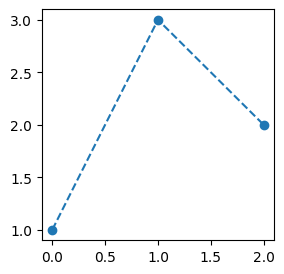

In [269]:
## 코드2
context_manager = FigureSizeContext()
with context_manager as resize:
    resize(3,3)
    plt.plot([1,3,2],'--o')

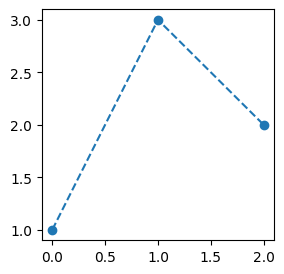

In [271]:
## 코드3
with FigureSizeContext() as resize:
    resize(3,3)
    plt.plot([1,3,2],'--o')    

`#`

`# 예제5` -- 샌드위치만들기

In [285]:
class 샌드위치생성기:
    def __init__(self, 빵="기본빵"):
        self.빵 = 빵
        self.재료들 = []
    def __enter__(self):
        print(f'---{self.빵}---')    
        return self # 보통이런패턴..
    def __exit__(self, *args):
        print(f'---{self.빵}---')
    def 재료추가하기(self,재료):
        print(재료)
        self.재료들.append(재료)

`-` 사용예시1

In [277]:
with 샌드위치생성기() as 샌드위치1:
    pass

---기본빵---
---기본빵---


In [282]:
샌드위치1.빵, 샌드위치1.재료들

('기본빵', [])

`-` 사용예시2

In [286]:
with 샌드위치생성기(빵='허니오토') as 샌드위치2:
    샌드위치2.재료추가하기('양상추')
    샌드위치2.재료추가하기('토마토')
    샌드위치2.재료추가하기('햄')

---허니오토---
양상추
토마토
햄
---허니오토---


In [288]:
샌드위치2.빵, 샌드위치2.재료들

('허니오토', ['양상추', '토마토', '햄'])

`-` 정리하면 `__enter__()` 의 리턴값이 `self`일 경우에 한정하여 아래의 문법이 같은효과.. (그런데 보통 이런 경우가 많음 )

In [290]:
with 샌드위치생성기(빵='허니오토') as 샌드위치2:
    샌드위치2.재료추가하기('양상추')
    샌드위치2.재료추가하기('토마토')
    샌드위치2.재료추가하기('햄')

---허니오토---
양상추
토마토
햄
---허니오토---


In [349]:
샌드위치2 = 샌드위치생성기(빵='허니오토')
샌드위치2 = 샌드위치2.__enter__()
샌드위치2.재료추가하기('양상추')
샌드위치2.재료추가하기('토마토')
샌드위치2.재료추가하기('햄')
샌드위치2.__exit__()

---허니오토---
양상추
토마토
햄
---허니오토---


In [350]:
샌드위치2 = 샌드위치생성기(빵='허니오토').__enter__()
샌드위치2.재료추가하기('양상추')
샌드위치2.재료추가하기('토마토')
샌드위치2.재료추가하기('햄')
샌드위치2.__exit__()

---허니오토---
양상추
토마토
햄
---허니오토---


In [351]:
샌드위치2 = 샌드위치생성기(빵='허니오토')
샌드위치2.__enter__()
샌드위치2.재료추가하기('양상추')
샌드위치2.재료추가하기('토마토')
샌드위치2.재료추가하기('햄')
샌드위치2.__exit__()

---허니오토---
양상추
토마토
햄
---허니오토---


`#`

`# 예제6`

`-` `example.txt` 를 만들고 "asdf" 라는 글자를 넣는 파이썬코드

In [342]:
with open("example.txt","w") as file:
    file.write("asdf")

In [343]:
!cat example.txt # example.txt 를 출력하는 리눅스 명령어..

asdf

`-` 분석하기.. 

In [344]:
context_manager = open("example.txt","w")
type(context_manager), type(file)

(_io.TextIOWrapper, _io.TextIOWrapper)

`-` 분석하기2: `__enter__` 가 `self`를 리턴하는지 보자

In [346]:
context_manager.__enter__??
# 코드를 볼수없음 -- 아쉽당..

Docstring: <no docstring>
Type:      builtin_function_or_method

`#`

`# 예제7` 

`-` `example.txt` 파일을 `example.tar.gz`로 압축하는 코드

In [347]:
with tarfile.open("example.tar.gz", "w:gz") as tar:
    tar.add("example.txt", arcname="example.txt")

`-` 분석하기 

In [331]:
context_manager = tarfile.open("example.tar.gz", "w:gz")
type(context_manager), type(tar)

(tarfile.TarFile, tarfile.TarFile)

`-` 분석하기2: `__enter__` 가 `self`를 리턴하는지 보자

In [333]:
context_manager.__enter__??
# 역시 셀프를 리턴하는 구조..

Signature: context_manager.__enter__()
Docstring: <no docstring>
Source:   
    def __enter__(self):
        self._check()
        return self
File:      ~/anaconda3/envs/hf/lib/python3.12/tarfile.py
Type:      method

`#`